In [2]:
import os, pathlib
import pandas as pd
import warnings

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
root = pathlib.Path("data")

In [4]:
codes = pd.read_csv(root / "census_codes.csv")
codes

,Code,Description,Filename
0,TS001,Number of usual residents in households and co...,census2021-ts001.zip
1,TS002,Legal partnership status,census2021-ts002.zip
2,TS003,Household composition,census2021-ts003.zip
3,TS004,Country of birth,census2021-ts004.zip
4,TS005,Passports held,census2021-ts005.zip
...,...,...,...
72,TS039,Provision of unpaid care,census2021-ts039.zip
73,TS040,Number of disabled people in the household,census2021-ts040.zip
74,TS037ASP,General health - age-standardised proportions,census2021-ts037asp.zip
75,TS038ASP,Disability - age-standardised proportions,census2021-ts038asp.zip


In [5]:
region_sizes = {"Country" : "ctry",
                "Region" : "rgn",
                "Upper-Tier Local Authority" : "utla",      #153 in England
                "Lower-Tier Local Authority" : "ltla",      #296 in England
                "Middle-Layer Super Output Area" : "msoa",  #2000-6000 households; 5000-15000 persons
                "Lower-Layer Super Output Area" : "lsoa",   #400-1200 households; 1000-3000 persons
                "Output Area" : "oa"}                       #40-250 households; 100-625 persons
region_indices = {3 : "ctry",
                  10 : "rgn",
                  174 : "utla",
                  331 : "ltla",
                  7264 : "msoa",
                  35672 : "lsoa",
                  188800 : "oa"}

regions = list(region_sizes.values())
regions

['ctry', 'rgn', 'utla', 'ltla', 'msoa', 'lsoa', 'oa']

In [6]:
def import_data(region : str, target_groups : list = None, target_codes: list = None): 
    '''Imports target census data\n
    Parameters:\n
        region, should be string of one of the following: ctry, rgn, utla, ltla, msoa, lsoa, oa\n
        target_groups, should be a list of strings of the descriptions of the data values as found at https://www.nomisweb.co.uk/census/2021/bulk\n
        target_codes, should be a list of strings of the codes of the data values as found at https://www.nomisweb.co.uk/census/2021/bulk\n
    Note: one of the two target parameters must be passed\n

    Returns dictionary of "Data type code" : Pandas DataFrame'''
    if target_groups == None and target_codes == None:
        raise ValueError("Need specified groups to import")
    
    region = str(region)
    if region not in regions:
        regions_error = '\n'.join(f"{key}  :  {val}" for key, val in region_sizes.items())
        raise ValueError(f"Region code must be one of the following: \nRegion  :  Region Code\n{regions_error}")
    
    codes = pd.read_csv(root / "census_codes.csv")
    codes["Filename"] = (
    codes["Filename"].str.split(".")
    .apply(lambda x: x[0])
    )

    if target_groups:
        valid_target_groups = [group for group in target_groups if group in codes["Description"].values]
        if len(valid_target_groups) == 0:
            raise ValueError("Inputs not found in code database, ensure the group names are as found on https://www.nomisweb.co.uk/census/2021/bulk")
        erroneous_groups = [group for group in target_groups if group not in valid_target_groups]
        output_erroneous_groups = '\n'.join(erroneous_groups)
        if len(erroneous_groups) > 0:
            warnings.warn(f"The following groups were not imported as they are invalid: {output_erroneous_groups}\nEnsure the group names are as found on https://www.nomisweb.co.uk/census/2021/bulk")
        
    if target_codes:
        valid_target_codes = [code for code in target_codes if code in codes["Code"].values]
        if len(valid_target_codes) == 0:
            raise ValueError("Inputs not found in code database, ensure codes are in the form 'TSXXX' where X's are digits, as found on https://www.nomisweb.co.uk/census/2021/bulk")
        erroneous_codes = [code for code in target_codes if code not in valid_target_codes]
        output_erroneous_codes = '\n'.join(erroneous_codes)
        if len(erroneous_codes) > 0:
            warnings.warn(f"The following codes were not imported as they are invalid: {output_erroneous_codes}\nEnsure codes are in the form 'TSXXX' where X's are digits, as found on https://www.nomisweb.co.uk/census/2021/bulk")
    
    if target_groups:
        try:
            valid_target_codes = valid_target_codes if valid_target_codes is not None else []
        except UnboundLocalError:
            valid_target_codes = []
        for group in valid_target_groups:
            valid_target_codes.append(codes.loc[codes["Description"] == group,"Code"].item())

    data = {}
    for code in valid_target_codes:
        folder = codes.loc[codes["Code"] == code, "Filename"].item()
        try:
            data.update({code : pd.read_csv(root / folder / f"{folder}-{region}.csv").drop(columns="date")})
        except FileNotFoundError:
            warnings.warn(f"File {folder}-{region}.csv not found in data/{folder}")
    
    return data

def import_all_data(region : str):
    '''Imports all installed census data\n
    Parameters:\n
        region, should be string of one of the following: ctry, rgn, utla, ltla, msoa, lsoa, oa\n
    Returns dictionary of "Data type code" : Pandas DataFrame
    '''
    region = str(region)
    if region not in regions:
        regions_error = '\n'.join(f"{key}  :  {val}" for key, val in region_sizes.items())
        raise ValueError(f"Region code must be one of the following: \nRegion  :  Region Code\n{regions_error}")

    codes = pd.read_csv(root / "census_codes.csv")
    codes["Filename"] = (
    codes["Filename"].str.split(".")
    .apply(lambda x: x[0])
    )
    
    data = {}
    for code in codes["Code"].values:
        folder = codes.loc[codes["Code"] == code, "Filename"].item()
        try:
            data.update({code : pd.read_csv(root / folder / f"{folder}-{region}.csv").drop(columns="date")})
        except FileNotFoundError:
            warnings.warn(f"File {folder}-{region}.csv not found in data/{folder}")
    
    return data

def cleanup_all(data : dict, remove_geography : bool = True, remove_geography_code : bool = True):
    '''
    Removes the specified columns from all dataframes\n
    Parameters:\n
        data, data to be cleaned, dictionary of "Data type code" : Pandas DataFrame\n
        remove_geography, whether to remove geography column, bool\n
        remove_geography-code, whether to remove geography code column, bool\n
        
    Returns dictionary of "Data type code" : Pandas DataFrame
    '''
    for key in data.keys():
        dataframe = data[key]
        try:
            if remove_geography:
                dataframe = dataframe.drop(columns="geography")
        except KeyError:
            pass
        try:
            if remove_geography_code:
                dataframe = dataframe.drop(columns="geography code")
        except KeyError:
            pass
        data[key] = dataframe
    return data

def cleanup(dataframe, columns : list):
    '''Removes specified columns from dataframe\n
    Parameters:\n
        dataframe, Pandas DataFrame to be cleaned\n
        columns, list of strings of column names to be removed\n
    '''
    if type(columns) is not list:
        raise ValueError("Parameter 'columns' must be a list")
    elif len([column for column in columns if type(column) is str]) == 0:
        raise ValueError("Parameter 'columns' must be a list of strings")  
    for column in columns:
        try:
            dataframe = dataframe.drop(columns=column)
        except KeyError:
            warnings.warn(f"Column {column} does not exist ")
    return dataframe

In [7]:
def factor_in_age(df):
    df_age = import_data(region_indices[len(df.index)], target_codes=["TS004"])["TS004"]
    df_age_totals_column = [column for column in list(df_age.columns) if "Total" in column][0]
    df_totals_column = [column for column in list(df.columns) if "Total" in column][0]
    df["Not Accounted For"] = df_age[df_age_totals_column] - df[df_totals_column]
    df[df_totals_column] = df_age[df_age_totals_column]
    df.rename(columns={df_totals_column:"Total"}, inplace=True)

    return df

   

In [8]:
def prob_calc(dataframe):
    probabilities = pd.DataFrame(dataframe)
    total = dataframe.loc[:,dataframe.columns[1]]
    
    count = 2

    # Iterates through columns in dataframe
    for num in range(len(dataframe.columns)-2):
        column = dataframe.loc[:,dataframe.columns[count]]
        cell_count = 0
        # Iterates through items in each column
        for row in column:
            #Divides current cell by the item at the start of the row
            probabilities.loc[:, dataframe.columns[count]].at[cell_count] = row / total[cell_count]
            cell_count += 1
        count += 1
    
    return probabilities

,geography,Total,Highest level of qualification: No qualifications,Highest level of qualification: Level 1 and entry level qualifications,Highest level of qualification: Level 2 qualifications,Highest level of qualification: Apprenticeship,Highest level of qualification: Level 3 qualifications,Highest level of qualification: Level 4 qualifications and above,Highest level of qualification: Other qualifications,Not Accounted For
0,North East,2647013,0.167124,0.078926,0.113958,0.054690,0.152782,0.235140,0.020556,0.176823
1,North West,7417399,0.158371,0.078610,0.110434,0.047713,0.143170,0.253465,0.020602,0.187635
2,Yorkshire and The Humber,5480774,0.167794,0.081935,0.110823,0.049942,0.141781,0.240013,0.021521,0.186192
3,East Midlands,4880054,0.159610,0.085057,0.113943,0.049021,0.149869,0.238478,0.023285,0.180738
4,West Midlands,5950759,0.170617,0.083134,0.112035,0.042547,0.137625,0.237570,0.023315,0.193157
5,East,6335074,0.147150,0.087604,0.117222,0.044855,0.136251,0.256568,0.023013,0.187337
6,London,8799726,0.130828,0.061964,0.080402,0.025867,0.106580,0.376924,0.024731,0.192704
7,South East,9278065,0.125265,0.079663,0.112825,0.041685,0.141576,0.291230,0.021996,0.185759
8,South West,5701186,0.130005,0.081732,0.118972,0.049744,0.153759,0.274815,0.021650,0.169324
9,Wales,3107494,0.164017,0.071770,0.118217,0.046119,0.141803,0.259622,0.022078,0.176373


,Highest Level of Qualification,Percentage,Region
0,No qualifications,16.712385,North East
1,Level 1 and entry level qualifications,7.892632,North East
2,Level 2 qualifications,11.395788,North East
3,Apprenticeship,5.468995,North East
4,Level 3 qualifications,15.278240,North East
...,...,...,...
3,Apprenticeship,4.611948,Wales
4,Level 3 qualifications,14.180301,Wales
5,Level 4 qualifications and above,25.962174,Wales
6,Other qualifications,2.207824,Wales


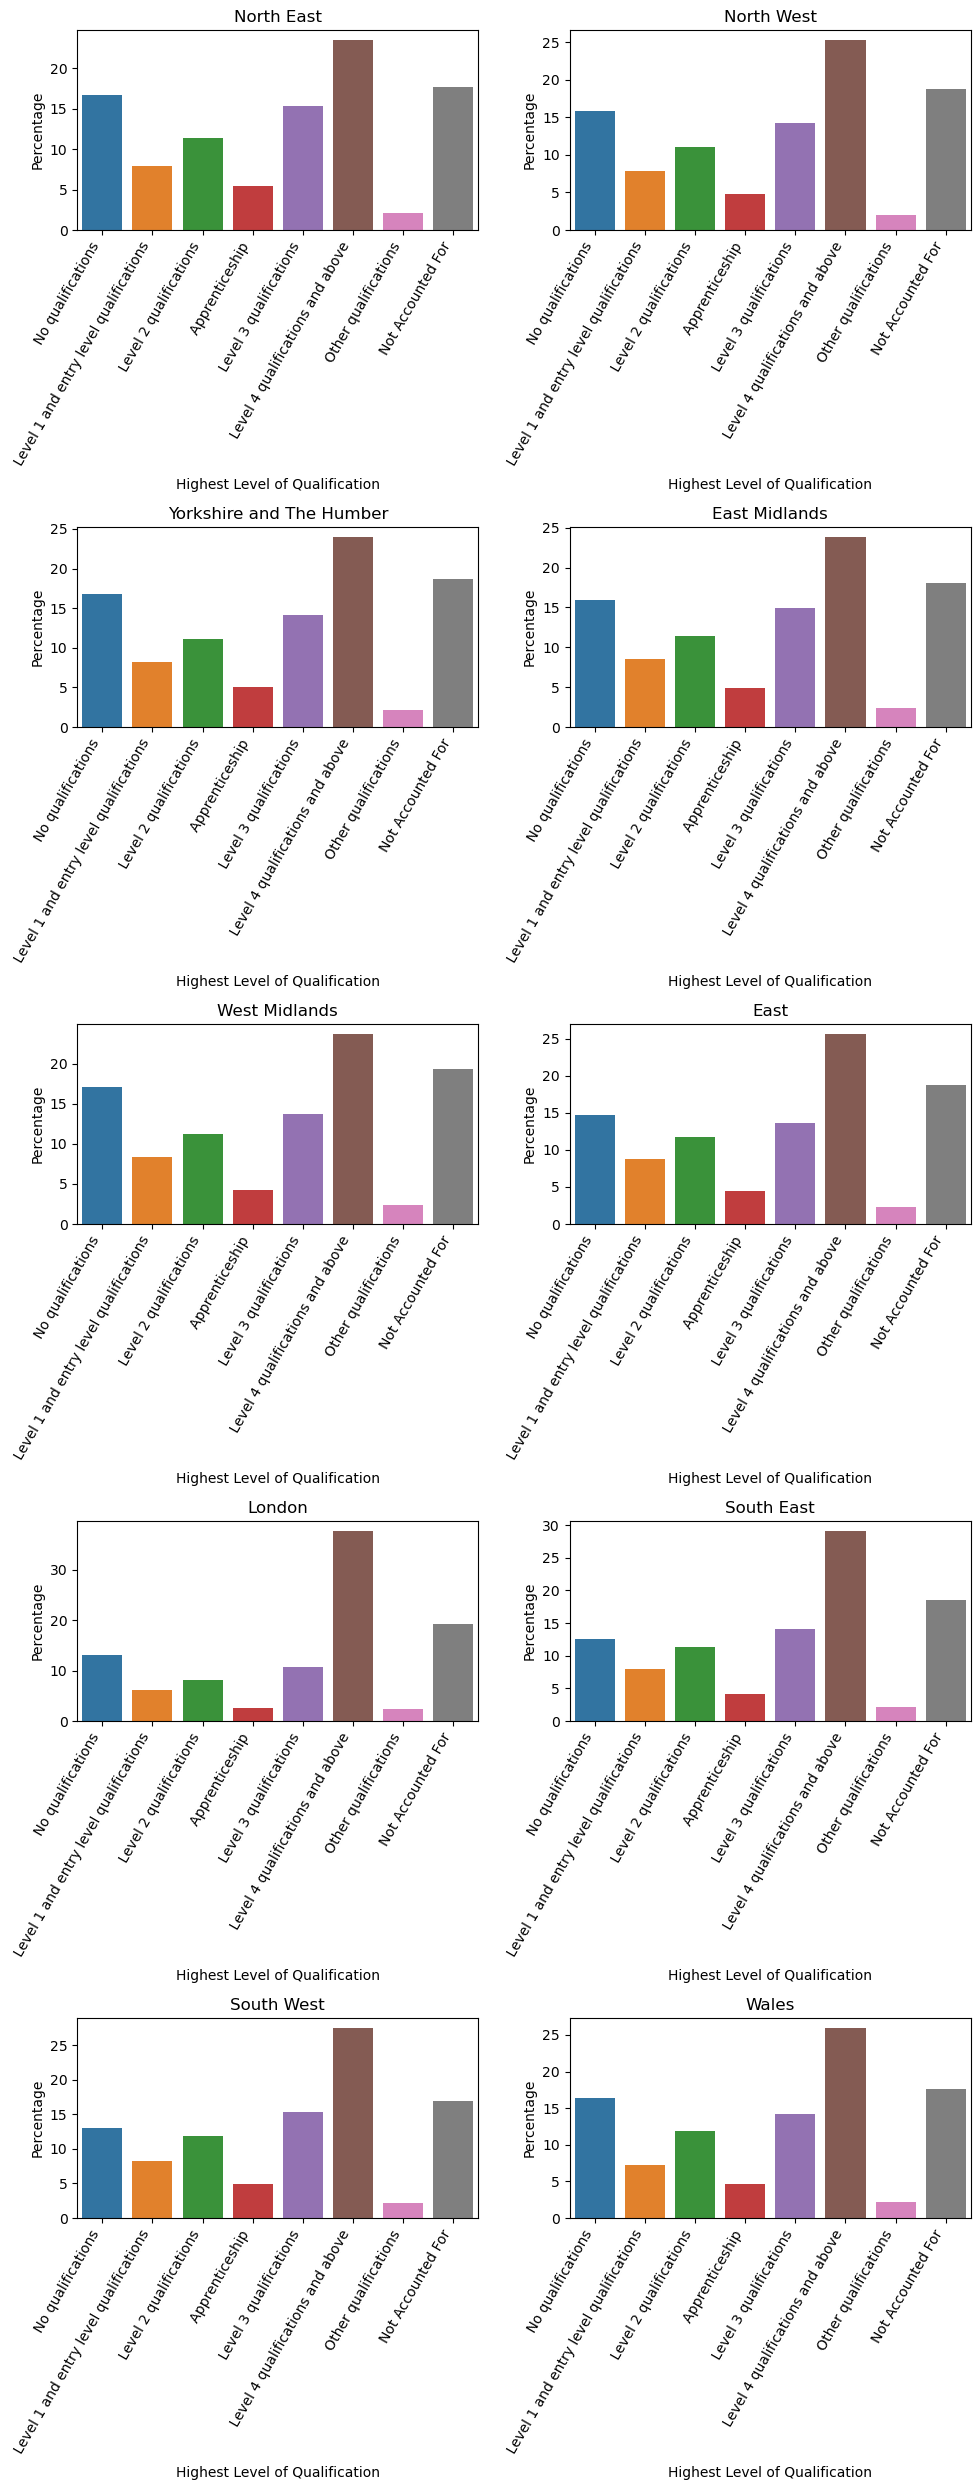

c:\Users\keo88794\AppData\Local\miniconda3\envs\censusNew\lib\site-packages\seaborn\categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


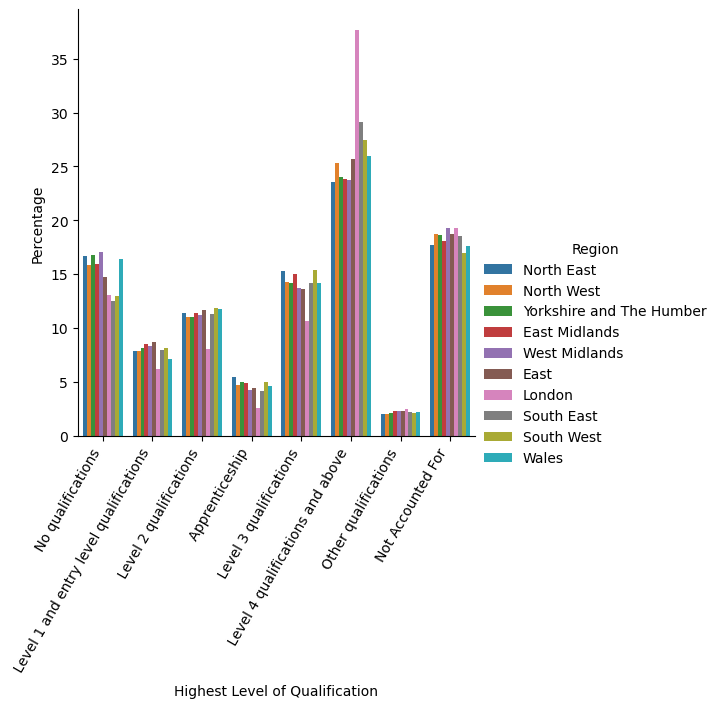